In [2]:
import pandas

orig_files = ["../../original-data/all/heldout_period_data.jsonlist.bz2",
              "../../original-data/all/train_period_data.jsonlist.bz2"]

data_file = "../../data/cmv.annotations.topics.jsonlist"

# Data stats

In [3]:
import json, bz2

def new_stats():
    return { "trees" : set([]), "replies" : set([]), "ops" : set([]), "participants" : set([])}

def calc_stats(file, stats):
    for line in file:
        cmv = json.loads(line)

        stats["trees"].add(cmv["id"])
        stats["participants"].add(cmv["author"])
        stats["ops"].add(cmv["author"])
        for comment in cmv["comments"]:
            if "author" not in comment:
                continue

            stats["replies"].add(comment["id"])
            stats["participants"].add(comment["author"])

def print_stats(stats):
    return "Trees: %i, Replies: %i, Nodes: %i, OPs: %i, Participants: %i" % (len(stats["trees"]),
                                                                            len(stats["replies"]), 
                                                                            len(stats["trees"]) + len(stats["replies"]),
                                                                            len(stats["ops"]),
                                                                            len(stats["participants"]))

orig_stats = new_stats()
for filename in orig_files:
    calc_stats(bz2.open(filename, 'rb'), orig_stats)

data_stats = new_stats()
calc_stats(open(data_file, "r"), data_stats)

print("Original data:", print_stats(orig_stats))
print("Preprocessed data:", print_stats(data_stats))

Original data: Trees: 20626, Replies: 1258035, Nodes: 1278661, OPs: 13708, Participants: 78652
Preprocessed data: Trees: 20407, Replies: 1254160, Nodes: 1274567, OPs: 13702, Participants: 78589


# Topic stats

In [4]:
from collections import Counter

topics_file = "../../annotations/topics.info"
topics = { line.split(":")[0] : line.split(":")[1].strip() for line in open(topics_file, "r") }

post_topics = [ ]

for line in open(data_file, "r"):
        cmv = json.loads(line)

        if "topic" in cmv:
            post_topics.append(topics[cmv["topic"]])

topics_freq = Counter(post_topics)
topics_freq.most_common(10)

[('-1_the_and_to_of', 6880),
 ('0_music_song_songs_listen', 327),
 ('1_black_white_racism_racist', 233),
 ('2_gun_guns_firearms_weapons', 231),
 ('3_abortion_fetus_prolife_abortions', 230),
 ('4_college_degree_education_students', 220),
 ('5_gender_transgender_trans_sex', 213),
 ('6_meat_animals_eating_eat', 200),
 ('7_climate_warming_global_change', 184),
 ('8_nsa_privacy_information_data', 167)]

# Gender stats

In [8]:
def calc_gender_stats(file):
    explicit = { "M_topic" : [ ], "F_topic" : [ ], "N_topic" : [ ], 
                 "M_reply_topic" : [ ], "F_reply_topic" : [ ], "N_reply_topic" : [ ],
                 "M_threads" : [ ], "F_threads" : [ ], "N_threads" : [ ],
                 "M_auth" : [ ], "F_auth" : [ ], "N_auth" : [ ],
                 "M_post" : [ ], "F_post" : [ ], "N_post" : [ ] }
    implicit = { "M_topic" : [ ], "F_topic" : [ ], "N_topic" : [ ], 
                 "M_reply_topic" : [ ], "F_reply_topic" : [ ], "N_reply_topic" : [ ], 
                 "M_threads" : [ ], "F_threads" : [ ], "N_threads" : [ ], 
                 "M_auth" : [ ], "F_auth" : [ ], "N_auth" : [ ],
                 "M_post" : [ ], "F_post" : [ ], "N_post" : [ ]}

    for line in file:
        cmv = json.loads(line)
    
        exp = cmv["explicit_gender"]
        if exp != "UNK":
            explicit[exp + "_post"].append(cmv["id"])
            explicit[exp + "_topic"].append(cmv["topic"])
            explicit[exp + "_auth"].append(cmv["author"])
            explicit[exp + "_threads"].append(cmv["id"])

        impl = cmv["author_gender"]
        if impl != "UNK":
            implicit[impl + "_post"].append(cmv["id"])
            implicit[impl + "_topic"].append(cmv["topic"])
            implicit[impl + "_auth"].append(cmv["author"])
            implicit[impl + "_threads"].append(cmv["id"])

        for comment in cmv["comments"]:
            exp = comment["explicit_gender"]
            if exp != "UNK":
                explicit[exp + "_reply_topic"].append(cmv["topic"])
                explicit[exp + "_auth"].append(comment["author"])
                explicit[exp + "_threads"].append(cmv["id"])

            impl = comment["author_gender"]
            if impl != "UNK":
                implicit[impl + "_reply_topic"].append(cmv["topic"])
                implicit[impl + "_auth"].append(comment["author"])
                implicit[impl + "_threads"].append(cmv["id"])

    return explicit, implicit

explicit_stats, implicit_stats = calc_gender_stats(open(data_file, "r"))

In [19]:
from collections import Counter

def print_topics(c, how_many=10):
    for t, f in dict(c.most_common(how_many)).items():
        if t == "-1":
            continue
        
        print("\_".join(topics[t].split("_")[1:]), " & ", f)

def print_stats(s):
    print("## Frequences:")
    
    print("Posts -- Men:", len(s["M_post"]), "Women:", len(s["F_post"]), "Other:", len(s["N_post"]))
    print("Replies -- Men:", len(s["M_reply_topic"]), "Women:", len(s["F_reply_topic"]), "Other:", len(s["N_reply_topic"]))
    print("Discussions --  Men:", len(set(s["M_threads"])), "Women:", len(set(s["F_threads"])), "Other:", len(set(s["N_threads"])))
    print("Authors --  Men:", len(set(s["M_auth"])), "Women:", len(set(s["F_auth"])), "Other:", len(set(s["N_auth"])))
    
    print("All posts:", len(set(s["M_post"] + s["F_post"] + s["N_post"])))
    print("All replies:", len(set(s["reply_M"] + s["reply_F"] + s["reply_N"])))
    print("All threads:", len(set(s["M_threads"] + s["F_threads"] + s["N_threads"])))  
    print("All authors:", len(set(s["M_auth"] + s["F_auth"] + s["N_auth"])))  


    print("M+F posts:", len(set(s["M"] + s["F"])))
    print("M+F replies:", len(set(s["reply_M"] + s["reply_F"])))
    print("M+F threads:", len(set(s["M_threads"] + s["F_threads"])))  
    print("M+F authors:", len(set(s["M_auth"] + s["F_auth"])))

print("##############")
print("## Explicit mentions:")
print("##############")
print_stats(explicit_stats)

print("##############")
print("## Implicit mentions:")
print("##############")
print_stats(implicit_stats)

##############
## Explicit mentions:
##############
## Frequences:
Posts -- Men: 299 Women: 89 Other: 8
Posts -- Men: ['5', '112', '-1', '5', '187', '14', '-1', '-1']
Replies -- Men: 1953 Women: 961 Other: 321
Discussions --  Men: 1357 Women: 693 Other: 175
Authors --  Men: 1640 Women: 674 Other: 158
299 89 8 41
All posts: 91
All replies: 168
All threads: 1812
All authors: 2456
M+F posts: 90
M+F replies: 168
M+F threads: 1741
M+F authors: 2312
##############
## Implicit mentions:
##############
## Frequences:
Posts -- Men: 2253 Women: 396 Other: 32
Posts -- Men: ['138', '18', '-1', '5', '44', '101', '-1', '-1', '112', '47', '-1', '84', '-1', '160', '-1', '5', '-1', '5', '23', '187', '212', '19', '18', '-1', '3', '-1', '-1', '-1', '12', '94', '-1', '-1']
Replies -- Men: 227261 Women: 53042 Other: 9433
Discussions --  Men: 18515 Women: 10119 Other: 3220
Authors --  Men: 1634 Women: 664 Other: 144
2253 396 32 126
All posts: 248
All replies: 264
All threads: 19081
All authors: 2442
M+F pos

<>:8: SyntaxWarning: invalid escape sequence '\_'
<>:8: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipykernel_2121118/3139697359.py:8: SyntaxWarning: invalid escape sequence '\_'
  print("\_".join(topics[t].split("_")[1:]), " & ", f)


# Plot gender of authors in posts

Two zeros (unknown words?): 256


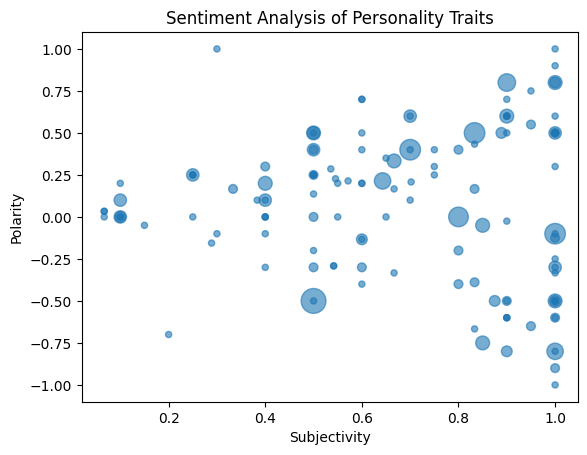

In [ ]:
interesting_topics = { }

def get_interesting_topics(stats):
    M_topics = Counter(stats["M"]) + Counter(stats["reply_M"])
    W_topics = Counter(stats["F"]) + Counter(stats["reply_F"])
    O_topics = Counter(stats["N"]) + Counter(stats["reply_N"])

    result = { }
    for (top, freq) in M_topics.most_common(500) + W_topics.most_common(500) + O_topics.most_common(500):
        if top == "-1":
            continue
        
        freq = M_topics[top] + W_topics[top] + O_topics[top]
        result[top] = freq

    result = [ (freq, top) for (top, freq) in result.items() ]
    result.sort(reverse=True)
    result = result[:10]
    print(result)
    return [ top for (_, top) in result ]
     
def reverse_stats(stats):
    interesting_keys = { "M" : 0, "F" : 0, "N" : 0, "reply_M" : 0, "reply_F" : 0, "reply_N" : 0 }
    result = { top : { "M" : 0, "F" : 0, "N" : 0, "reply_M" : 0, "reply_F" : 0, "reply_N" : 0 } for top in topics }
    for key, tops in stats.items():
        if key not in interesting_keys:
            continue
        
        for top in tops:
            result[top][key] += 1
    return result

tstats = reverse_stats(explicit_stats)
interesting_topics = get_interesting_topics(explicit_stats)[:10]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

fontsize=14
labelpad=12

def setFontSize():
    rcParams.update({'text.usetex': False}) 
    rcParams.update({'font.size': fontsize})
    rcParams.update({'legend.fontsize': fontsize})
    rcParams.update({'axes.titlesize': fontsize})
    rcParams.update({'axes.labelsize': fontsize})

def setFigureSize():
    fig_size = rcParams["figure.figsize"]
    fig_size[0] = 8
    fig_size[1] = 3
    rcParams["figure.figsize"] = fig_size

def nice_title(title):
    parts = title.split("_")[1:-1]
    result = [ ]
    for p in parts:
        if p == "circumcised":
            p = "infant"

        result.append(p)
    
    return ", ".join(result).capitalize()

# Sample data for three series
categories = [ nice_title(topics[top]) for top in interesting_topics[::-1] ]
men = [ tstats[top]["M"] + tstats[top]["reply_M"] for top in interesting_topics[::-1] ]
women = [ tstats[top]["F"] + tstats[top]["reply_F"] for top in interesting_topics[::-1] ]
other = [ tstats[top]["N"] + tstats[top]["reply_N"] for top in interesting_topics[::-1] ]

print(men)
print(women)
print(other)

setFontSize()
setFigureSize()

# Create an array for the y-axis positions
y = np.arange(len(categories))

# Create the stacked bar plot
plt.barh(y, men, label='male', alpha=0.7)
plt.barh(y, women, label='female', alpha=0.7, left=men)
plt.barh(y, other, label='other', alpha=0.7, left=np.array(men) + np.array(women))

# Add labels, title, and legend
#plt.xlabel('Categories')
plt.xlabel('Number of nodes (posts and replies)')
cats = plt.yticks(y, categories)
plt.legend()

rcParams.update({'figure.autolayout': True})

# Show the plot
plt.show()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


200 200 200
